In [18]:
import numpy as np
import matplotlib.pyplot as plt

In [19]:
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

In [20]:
# for a point x, y, find the closest K points from the dataset
# determine class label of new point: 
# in the non weighted version of KNN, it is the class of the majority of the closest neighbors
# in the weighted version, it is the class for which the sum of the corresponding neighbor weights is the highest 

def knn(train_points, train_labels, new_point, k, weighted=False):
    distances = [(euclidean_distance(new_point, train_points[index]), train_labels[index]) for index in range(len(train_points))]
    distances.sort(key=lambda x: x[0])  # sortam distantele crescator
    k_nearest = distances[:k]  # cei mai apropiati k vecini
    
    if not weighted:
        # calc histograma pt vecini
        class_histogram = np.bincount([label for (_, label) in k_nearest])
        # returnam clasa cu cele mai multe aparitii
        return np.argmax(class_histogram)
    else:
        class_weights = {}
        for distance, label in k_nearest:
            if distance == 0:
                continue
            if label not in class_weights:
                class_weights[label] = 0
            class_weights[label] += 1 / distance ** 2  # inversul patratic al distantei
        # returnam clasa cu suma ponderilor maxima
        return max(class_weights, key=class_weights.get)

In [21]:
def calculate_classification_error(train_points, train_labels, validation_points, validation_labels, k, weighted=False):
    predictedLabels = [knn(train_points, train_labels, point, k, weighted) for point in validation_points]
    incorrectClassifications = sum(1 for true_label, predicted_label in zip(validation_labels, predictedLabels) if true_label != predicted_label)
    return incorrectClassifications / len(validation_points)

In [22]:
def cross_validation(train_points, train_labels, n_folds, k_max):
    fold_size = len(train_points) // n_folds
    errors_per_k = []

    for k in range(1, k_max + 1):
        total_error = 0

        for i in range(n_folds):
            # impartim datele in "folduri" de antrenare și testare
            test_fold_points = train_points[i * fold_size: (i + 1) * fold_size]
            test_fold_labels = train_labels[i * fold_size: (i + 1) * fold_size]
            train_fold_points = np.concatenate([train_points[:i * fold_size], train_points[(i + 1) * fold_size:]])
            train_fold_labels = np.concatenate([train_labels[:i * fold_size], train_labels[(i + 1) * fold_size:]])

            # calc eroarea de clasificare pentru foldul curent
            error = calculate_classification_error(train_fold_points, train_fold_labels, test_fold_points, test_fold_labels, k)
            total_error += error

        # calc eroarea medie pentru valoarea curenta a lui k
        average_error = total_error / n_folds
        errors_per_k.append(average_error)

    # det cea mai buna val a lui k
    best_k = np.argmin(errors_per_k) + 1
    best_error = errors_per_k[best_k - 1]

    return best_k, best_error

In [23]:
inFile = open('knnpoints.txt', 'r')
N = int(inFile.readline())
dataset = np.zeros([N, 3])
for i in range(N):
    pt = inFile.readline()
    pt = pt.split()
    dataset[i, 0] = float(pt[0]) #x
    dataset[i, 1] = float(pt[1]) #y
    dataset[i, 2] = float(pt[2]) #class label

In [24]:
#class labels are 0 - red , 1 - green
np.random.shuffle(dataset)
points = dataset[:, :2]
labels = dataset[:, 2]

print(points.size)

200


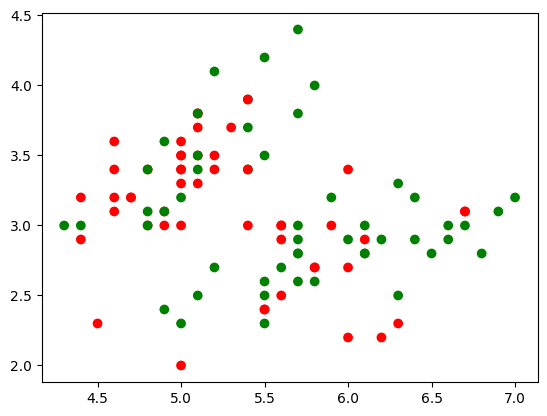

In [25]:
labelColors = ['red', 'green']
unlabeledColor = 'black'

pointColors = [labelColors[int(labels[i])] for i in range(N)]
plt.scatter(points[:,0], points[:,1], color = pointColors)

In [26]:
# divizam setul de date: 60% antrenare, 20% testare, 20% validare
train_size = int(0.6 * N)
validation_size = int(0.2 * N)
test_size = N - train_size - validation_size

# impartim seturile de date pentru antrenare, validare și testare
train_pts = points[:train_size]
train_lbs = labels[:train_size]
validation_pts = points[train_size:train_size + validation_size]
validation_lbs = labels[train_size:train_size + validation_size]
test_pts = points[train_size + validation_size:]
test_lbs = labels[train_size + validation_size:]

print(train_pts.size)
print(validation_pts.size)
print(test_pts.size)

120
40
40


In [27]:
# Validare simpla: pt fiec val k de la 1 la k_max se det err de clasif pt pucntele din multimea de validare folosind vecinii preluati din multimea de antrenare. 
# Cea mai buna val a lui k este at cand avem err minima
# definim kmax pentru calc erorii la validare
k_max = 10
errors = []
for k in range(1, k_max + 1):
    error = calculate_classification_error(train_pts, train_lbs, validation_pts, validation_lbs, k)
    errors.append(error)   
    
# det cea mai buna valoare a lui K
best_k = np.argmin(errors) + 1
best_error = errors[best_k - 1]

print("Cea mai buna valoare a lui K:", best_k)
print("Eroarea de clasificare minima pe setul de validare:", best_error)


Cea mai buna valoare a lui K: 1
Eroarea de clasificare minima pe setul de validare: 0.35


In [28]:
# Validare incrucisata: se imparte multimea datelor in multime de antrenare si testare. pt cea de antrenare, 
# formam subgrupuri egale astfel incat avem n-1 subgrupuri de antrenare si un subgrup de test. pentru fiec val a lui k, alegem eroare medie din toate subgrup.

# aici datele inca sunt impartite 60/20/20 chiar daca multimea de validare nu este folosita.

# param pentru cross-validation
n_folds = 5  # Numărul de folduri
k_max = 10  # Valoarea maximă a lui K pentru care vom căuta cea mai bună valoare

# aplicam cross-validation
best_k, best_error = cross_validation(train_pts, train_lbs, n_folds, k_max)

print("Cea mai buna valoare a lui K identificata prin cross-validation:", best_k)
print("Eroarea medie de clasificare pentru cea mai buna valoare a lui K:", best_error)

# testam clasificatorul cu cea mai buna valoare a lui K folosind multimea de test
test_error = calculate_classification_error(train_pts, train_lbs, test_pts, test_lbs, best_k)
print("Eroarea de clasificare pe setul de testare folosind cea mai buna valoare a lui K:", test_error)

Cea mai buna valoare a lui K identificata prin cross-validation: 6
Eroarea medie de clasificare pentru cea mai buna valoare a lui K: 0.3166666666666667
Eroarea de clasificare pe setul de testare folosind cea mai buna valoare a lui K: 0.45


In [29]:
#find labels of myPoints ...
predicted_labels = [knn(train_pts, train_lbs, point, k=best_k, weighted=True) for point in test_pts]

In [30]:
# calc numarul de puncte clasificate gresit in setul de testare
incorrect_classifications = sum(1 for true_label, predicted_label in zip(test_lbs, predicted_labels) if true_label != predicted_label)

# calc eroarea de clasificare
classification_error = incorrect_classifications / len(test_pts)

print("Eroarea de clasificare pentru KNN:", classification_error)

Eroarea de clasificare pentru KNN: 0.35


In [31]:
# plt.scatter(myPoints[:,0], myPoints[:,1], color = unlabeledColor, s = 60, marker='x')
# point_colors = [labelColors[int(label)] for label in labels]
# plt.scatter(points[:, 0], points[:, 1], color=pointColors)
# plt.scatter(myPoints[:, 0], myPoints[:, 1], color=[labelColors[label] for label in predicted_labels], s=60, marker='x')
# plt.show()

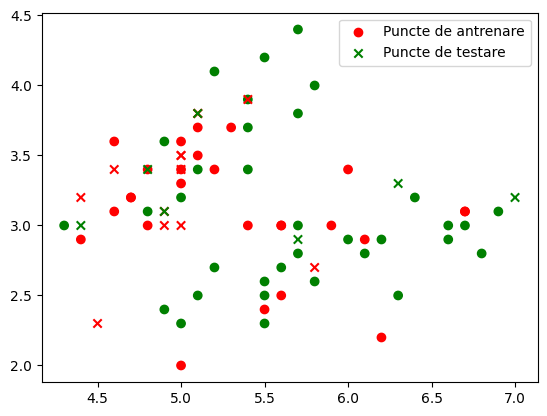

In [32]:
# plotare puncte de antrenare
train_point_colors = [labelColors[int(label)] for label in train_lbs]
plt.scatter(train_pts[:, 0], train_pts[:, 1], color=train_point_colors, 
            label='Puncte de antrenare')

# plotare puncte de testare
test_point_colors = [labelColors[int(label)] for label in test_lbs]
plt.scatter(test_pts[:, 0], test_pts[:, 1], color=test_point_colors, marker='x', 
            label='Puncte de testare')

plt.legend()
plt.show()

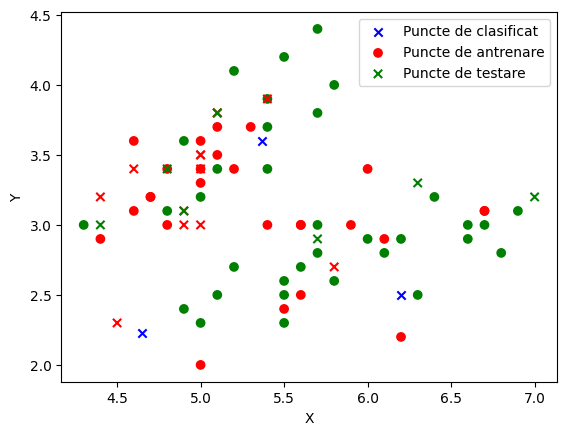

Clasele prezise pentru punctele de clasificat cu best_k: 9: ['green', 'green', 'green']


In [33]:
# Definim punctele de clasificat
best_k = 9
myPoints = np.array([[6.2, 2.5], [5.37, 3.6], [4.65, 2.23]])
# Calculam clasa pentru fiecare punct folosind cea mai buna valoare a lui K
predicted_labels = [knn(train_pts, train_lbs, point, best_k, True) for point in myPoints]
# Plasam punctele pe grafic
plt.scatter(myPoints[:, 0], myPoints[:, 1], color='blue', marker='x', label='Puncte de clasificat')
plt.scatter(train_pts[:, 0], train_pts[:, 1], color=train_point_colors, label='Puncte de antrenare')
plt.scatter(test_pts[:, 0], test_pts[:, 1], color=test_point_colors, marker='x', label='Puncte de testare')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()
# Afisam clasele prezise pentru punctele de clasificat
point_colors = [labelColors[int(label)] for label in predicted_labels]
print(f"Clasele prezise pentru punctele de clasificat cu best_k: {best_k}:", point_colors)
